In [1]:
from __future__ import print_function
 
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.recurrent import LSTM,GRU
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

from keras.models import model_from_json
import numpy as np
import json
import requests
import pandas as pd

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df_all = pd.read_csv('data/19999_question_category_a_v11.csv')
print(f"df_all shape : {df_all.shape}")

df_all shape : (10151, 8)


In [3]:
mapping = df_all.category.astype('category').cat.categories
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [4]:
from NLP_JiebaSegmentor import JiebaSegmentor
jieba_dict_path1 = "jieba/dict_taiwan.txt"
jieba_dict_path2 = "jieba/userdict.txt"
jieba_dict_path3 = "jieba/dict.txt.big"
jieba_dict_path4 = "jieba/dict.txt.small"
jieba_dict_path5 = "jieba/dict_system.txt"
jieba_stopwords_path = "jieba/stopwords.txt"

js = JiebaSegmentor(dict_path=jieba_dict_path1,
                    userdict=[jieba_dict_path2,
                              jieba_dict_path3,
                              jieba_dict_path4,
                              jieba_dict_path5],
                    stopwords=True,
                    stopwords_path=jieba_stopwords_path)

Building prefix dict from /project/at081-group3/Project_19999/19999_CNN/jieba/dict_taiwan.txt ...
Dumping model to file cache /tmp/jieba.u1430022de19ce5d7760cc83d31504a1a.cache
Loading model cost 0.769 seconds.
Prefix dict has been built succesfully.


In [5]:
test_cut_raw_0 = js.lcut('FTP無法安裝', return_type='pandas')
test_cut_raw_0

,word
0,FTP
1,無法安裝


In [6]:
# x_train=np.loadtxt("x_train.txt",dtype=int)
# y_train=np.loadtxt("y_train.txt",dtype=int)
 
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)
# x_train = x_train[indices]
# y_train = y_train[indices]
 
# print('Loading data...')
# #x_train=np.loadtxt("x_train.txt",dtype=int)
# #y_train=np.loadtxt("y_train.txt",dtype=int)
# x_test=x_train[20000:]
# y_test=y_train[20000:]
# x_train=x_train[:20000]
# y_train=y_train[:20000]
# #x_test=x_train
# #y_test=y_train
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')
# print(x_train[:1])
# print('Pad sequences (samples x time)')

In [7]:
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target
0,"無法會員登入,顯示訊息:無效的帳號或使用者不存在。帳號:96122401",CAMP,CAMP,CAMP,CAMP,資訊系統,無法會員登入 顯示訊息 無效的帳號或不存在 帳號,4
1,因今天有事請假，要補登先前的加班，但開啟camp後，出勤表單顯示的內容看起來像測試的，沒有最...,CAMP,CAMP,CAMP,CAMP,資訊系統,因有事請假 要補登先前的加班 但開啟camp後 出勤表單顯示的內容像測試的 沒有的時間也沒辦...,4
2,"手機簽核BPM有問題,都顯示亂碼 #18227",CAMP,CAMP,CAMP,CAMP,資訊系統,簽核BPM有問題 都顯示亂碼,4
3,無法在手機上面使用CAMP進行表單簽核動作。分機：17132,CAMP,CAMP,CAMP,CAMP,資訊系統,無法在上面使用CAMP進行表單簽核動作,4
4,"出差同仁無法登入camp, 委請同事詢問",CAMP,CAMP,CAMP,CAMP,資訊系統,出差同仁無法登入camp 委請同事詢問,4


In [8]:
# w_pandas = js.lcut('無法會員登入 顯示訊息 無效的帳號或不存在 帳號'.strip(), return_type='pandas')
# w_list = list(w_pandas['word'])
# w_list

In [9]:
def cut_to_word(s):
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
        combie = combie + w
        if i < len(w_list) - 1:
            combie = combie + ','
            
    return combie    

# print (cut_to_word('可以幫我聯絡'.strip()))
df_all['cut_words'] = df_all['description_clean'].apply(lambda s: cut_to_word(s.strip()))

In [12]:
# 資料打散
df_all = df_all.sample(frac=1).reset_index(drop=True)
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
0,MRO#APP0455569 (PO#1900073981) / APP0451801 (P...,BPM平台系統,採購類相關服務,MRO採購系統(MRO2),關卡流程詢問,資訊系統,MRO APP69 PO / APP01 PO were spped to QC...,4,"MRO,APP69,PO,APP01,PO,were,spped,to,QCA,Buildi..."
1,"你好, 今天下午郵件無法正常收到, 確認過對方寄出兩次, 我自己寄給自己也收不到",網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,下午郵件無法正常收到 確認過對方寄出兩次 我寄給也收不到,0,"下午,郵件,無法,正常,收到,確認,對方,寄出,兩次,寄給,收不到"
2,偶而會收不到qsmc寄過來的信,網管,Outlook與郵件,郵件傳送追蹤,沒有收到某封郵件,Outlook與郵件,會收不到qsmc寄過來的信,0,"收不到,qsmc,寄過來,信"
3,分機: 218158 問題: 網域認證過期，無法認證,網管,作業系統與印表機,作業系統問題,密碼過期,其他,網域認證過期 無法認證,2,"網域,認證,過期,無法,認證"
4,"出現無法指派IP給此電腦的錯誤訊息,請協助處理,謝謝",網管,網路,電腦網路不通,網路不通 (QRDC),網路,出現無法指派IP給此電腦的錯誤訊息,3,"出現,無法,指派,IP,給此,電腦,錯誤訊息"


In [13]:
df_all[3040:4010]

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
3040,"網路不通,網孔A227",網管,網路,電腦網路不通,網路不通 (QRDC),網路,網路不通 網孔A227,3,"網路不通,網孔,A227"
3041,"ZP33 back BOM 跑不出來,status:cancle",SAP-168(QCI),PP,BOM,BOM Create Error,SAP,ZP33 back BOM 跑不 status cancle,1,"ZP33,back,BOM,跑,status,cancle"
3042,一般資料可列印．sap資料無法列印,SAP-168(QCI),Basis,印表機,無法列印,SAP,資料可列印.sap資料無法列印,1,"資料,列印,sap,資料,無法,列印"
3043,網路持續出現驗證訊息,網管,網路,電腦網路不通,網路不斷出現驗證訊息,網路,網路持續出現驗證訊息,3,"網路,持續,出現,驗證,訊息"
3044,CCBU01 10.242.184.38 連不上。,網管,網路,無法連到某台Server,無法連到某些Server,網路,CCBU01 10.242.184.38 連不上,3,"CCBU01,10.242,184.38,連不上"
3045,使用者反應印表機網路列印無法使用，請協助處理,網管,作業系統與印表機,印表機問題,印表機無法列印,其他,印表機網路列印無法使用,2,"印表機,網路,列印,無法使用"
3046,使用者反應昨天更換密碼後無法登入帳號，請協助處理，聯絡分機：(381)10247，謝謝,網管,作業系統與印表機,作業系統問題,密碼遺忘,其他,更換密碼後無法登入帳號,2,"更換,密碼,後,無法,登入帳號"
3047,無法登入顯示CS33錯誤,SAP-2X8(QSMC),Basis,帳號,帳號無法使用,SAP,無法登入顯示CS33錯誤,1,"無法登入,顯示,CS33,錯誤"
3048,vista 無法上無線，可否直接upgrade到Window7 ，不會更新到裡面的設定 E...,網管,作業系統與印表機,作業系統問題,電腦無法登入,其他,vista 無法上無線 可否直接upgrade到Window7 更新到裡面的設定,2,"vista,無法,無線,可否,直接,upgrade,到,Window7,更新,到,裡面,設定"
3049,17327 SAP第二層 無法Logon,SAP-2X8(QSMC),Basis,帳號,帳號無法使用,SAP,SAP第二層 無法Logon,1,"SAP,第二層,無法Logon"


In [14]:
# 切分資料
X = df_all['cut_words']
y = df_all['category_target']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 40)

In [16]:
X_train.head()

3107                                     客戶,帳號,10,目前,無法登入
4726                        廠商,寄信,到,廣達,時常,退件,訊息,收件人,空間,正常
9812    最,左邊,那欄,收件,匣,後面,13,顯示,未讀,郵件,看到,未讀,郵件,10,月,中,收件...
6820                                    SAP,168,無法登入,2832
9152                              VPN,軟體,安裝,完,無法,正常,連回,公司
Name: cut_words, dtype: object

In [17]:
# label 做 onehot
y_train_one_hot = np_utils.to_categorical(y_train)
y_val_one_hot = np_utils.to_categorical(y_val)
print (y_train_one_hot[0])
print (y_val_one_hot[0])
# 總共類別數
num_classes = len((y_train_one_hot[0]))
print ('num_classes = {}'.format(num_classes))

[0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0.]
num_classes = 5


In [18]:
# # 標點符號過濾
# WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
NUM_WORDS = 5001
# 向量長度
MAX_LEN = 30

token_intent = Tokenizer(num_words=NUM_WORDS,
                        split=",")
# token_intent = Tokenizer(filters=WORD_FILTERS,
#                         num_words=NUM_WORDS,
#                         split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
token_intent.fit_on_texts(X_train)
token_intent.fit_on_texts(X_val)

def preprocessing(x, max_len):

    #將文字轉為數字序列
    train_seq_intent = token_intent.texts_to_sequences(x)

    # 截長補短，讓所有數字序列長度一樣
    data = sequence.pad_sequences(train_seq_intent, maxlen=MAX_LEN)
    # print train_data_intent.shape
    return data

x_train = preprocessing(X_train, max_len=MAX_LEN)
x_val = preprocessing(X_val, max_len=MAX_LEN)

In [19]:
x_train

array([[   0,    0,    0, ...,   39,   37,   11],
       [   0,    0,    0, ..., 1536,  321,   21],
       [   0,    0,    0, ...,   21, 2790,   25],
       ...,
       [   0,    0,    0, ..., 1155,    8,   47],
       [   0,    0,    0, ...,  107,  263, 2182],
       [   0,    0,    0, ...,   15,  855,  101]], dtype=int32)

In [20]:
# set parameters:
max_features = 5001
maxlen = 100
batch_size = 20
embedding_dims = 50
filters = 100
kernel_size = 10
hidden_dims = 250
epochs = 20
train_ratio = 0.9

In [21]:
def build_1DCNN_model(num_classes, vocab_size, sentence_max_len):
    print('Build model...')
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=256, 
                        input_length=sentence_max_len))

    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
                     
    # We add a vanilla hidden layer:
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [22]:
model = build_1DCNN_model(num_classes, NUM_WORDS, MAX_LEN)
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 256)           1280256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 100)           256100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0     

In [23]:
model_history = model.fit(x_train, y_train_one_hot,
          batch_size=batch_size,
          epochs=epochs,
          validation_split= 1 - train_ratio)

Train on 8221 samples, validate on 914 samples
Epoch 1/20
8221/8221 [==============================] - 5s 577us/step - loss: 1.2655 - acc: 0.4569 - val_loss: 0.7798 - val_acc: 0.7210
Epoch 2/20
8221/8221 [==============================] - 2s 282us/step - loss: 0.6099 - acc: 0.8043 - val_loss: 0.5757 - val_acc: 0.8260
Epoch 3/20
8221/8221 [==============================] - 2s 281us/step - loss: 0.3971 - acc: 0.8801 - val_loss: 0.6068 - val_acc: 0.8085
Epoch 4/20
8221/8221 [==============================] - 2s 280us/step - loss: 0.3025 - acc: 0.9086 - val_loss: 0.6387 - val_acc: 0.8129
Epoch 5/20
8221/8221 [==============================] - 2s 289us/step - loss: 0.2175 - acc: 0.9380 - val_loss: 0.7254 - val_acc: 0.8260
Epoch 6/20
8221/8221 [==============================] - 2s 279us/step - loss: 0.1712 - acc: 0.9492 - val_loss: 0.7567 - val_acc: 0.8074
Epoch 7/20
8221/8221 [==============================] - 2s 279us/step - loss: 0.1431 - acc: 0.9595 - val_loss: 0.9107 - val_acc: 0.8074
E

In [24]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


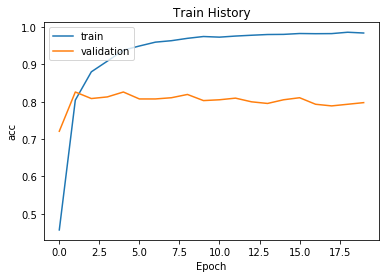

In [25]:
show_train_history(model_history,'acc','val_acc')

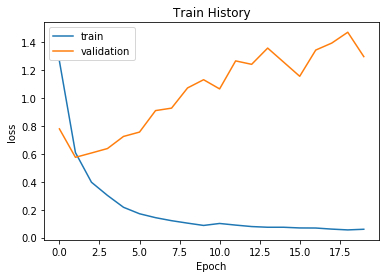

In [26]:
show_train_history(model_history,'loss','val_loss')

In [27]:
def to_cat_name(x): 
        return mapping[x]
    
def predict(test):
#     model = load_model(model_path)
    y_predict_probability = model.predict(test)
    y_predict = model.predict_classes(test)

    return to_cat_name(y_predict), y_predict, y_predict_probability

y_predict_name, y_predict, y_predict_probability = predict(x_val)

In [28]:
answer_name = to_cat_name(y_val)

In [29]:
model.predict_classes(x_val)

array([1, 2, 4, ..., 0, 4, 4])

In [30]:
x_val

array([[   0,    0,    0, ...,    1,  136,    8],
       [   0,    0,    0, ...,  302,   32, 1115],
       [   0,    0,    0, ..., 1781, 2896,  240],
       ...,
       [   0,    0,    0, ...,   24,   81,  514],
       [   0,    0,    0, ...,  229,    7, 1420],
       [   0,    0,    0, ...,  919,  236, 4910]], dtype=int32)

In [31]:
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [32]:
# model.predict(x_val)

In [33]:
# predict_df = pd.DataFrame({'1_sentence':df_test.sentence,
#               '2_y_predict':y_predict,
#               '3_y_predict_name':y_predict_name,
#               '4_answer':df_test.target,
#               '5_y_predict_probability':list(y_predict_probability)})
# predict_df

In [34]:
predict_df = pd.DataFrame({
              '1_sentence':X_val,
              '2_y_predict':y_predict,
              '3_y_predict_name':y_predict_name,
              '4_answer':y_val,
              '5_answer_name':answer_name,
              '6_y_predict_probability':list(y_predict_probability)})
# predict_df

In [35]:
# accuracy
accuracy = 1 - (float(len(predict_df[predict_df['2_y_predict'] != predict_df['4_answer']])))/(len(predict_df))
print ('accuracy : {} !!!!!!!!'.format(accuracy))

accuracy : 0.8061023622047244 !!!!!!!!


In [36]:
predict_df[predict_df['2_y_predict'] != predict_df['4_answer']]

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
4830,"Open,VPN,無法,成功,無法使用,SAP,持續,顯示,設定,中",1,SAP,3,網路,"[5.788095e-06, 0.9527903, 0.0048052617, 0.0423..."
5376,"反映,PLM,系統,忘記密碼,無法,問題,酖,找到,系統分類,任意,選,一個",2,其他,4,資訊系統,"[1.1382421e-09, 2.7581928e-11, 0.9999901, 2.33..."
2576,"辦法,進入,BPM,系統",3,網路,4,資訊系統,"[0.0035736563, 0.0035334537, 0.36987424, 0.597..."
4974,"電腦,無法登入,別台,電腦,原先,抓,無線網路,重,開機",3,網路,2,其他,"[2.3754338e-13, 7.5514505e-23, 8.610036e-09, 1..."
1666,"中午,更新,完畢,wIN10,更新,後,無法正常登入,網頁",2,其他,3,網路,"[3.003929e-17, 7.935172e-21, 1.0, 3.0848886e-0..."
9578,"工作,機,右下角,網路,連線,出現,黃色,驚嘆號,檢查,網路,連線,顯示,無,網路,存取,狀...",2,其他,3,網路,"[9.087992e-09, 1.1809743e-11, 0.99982435, 0.00..."
9684,"灌,Windows,之後,網路,連不上",2,其他,3,網路,"[7.0646444e-10, 8.307364e-12, 0.9997665, 0.000..."
4595,"開啟,outlook,中,pdf,文件,出現,無法開啟,錯誤訊息,嘗試,重,開機,之後,有時...",0,Outlook與郵件,2,其他,"[0.9876993, 2.1099487e-08, 0.012269664, 6.3940..."
4757,"無線網路,無法使用,進入,裝置,管理員,發現,無線,網卡,停用,狀態,右鍵,點選,啟用,後,...",3,網路,2,其他,"[2.8276638e-05, 1.4861394e-06, 0.02380483, 0.9..."
9494,"BU1,重要,客戶,Kona,代號,反應,email,退回,回覆,信息,outlook,只,...",2,其他,0,Outlook與郵件,"[0.32663253, 0.004002607, 0.5740928, 0.0563389..."


In [37]:
# confusion matrix
pd.crosstab(np.array(y_predict_name), np.array(answer_name),
            rownames=['predict'], colnames=['answer'])

answer,Outlook與郵件,SAP,其他,網路,資訊系統
predict,,,,,
Outlook與郵件,166,0,13,3,8
SAP,0,111,4,10,8
其他,8,4,269,32,20
網路,1,4,41,170,12
資訊系統,3,3,17,6,103


In [35]:

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
# loaded_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# score = loaded_model.evaluate(x_test, y_test, verbose=0)
# print(score)